In [25]:
from ase.io import read
import numpy as np
from matplotlib import pyplot as plt
import joblib, pickle, sys
from ase.lattice.cubic import FaceCenteredCubic, Diamond
from scipy.optimize import leastsq, minimize
from ase.build import bulk
from ase.optimize import LBFGS, FIRE, MDMin
from ase.md.langevin import Langevin
from ase import constraints
from ase.constraints import StrainFilter
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution
from ase.md.verlet import VelocityVerlet
from ase import units, Atoms
from ase.calculators.lj import LennardJones

sys.path.insert(0,"/home/claudio/postdoc/Castle/")
from castle import ASEMLCalculator, AceGlobalRepresentation, AceLocalRepresentation, LPEnsamble, LinearPotential
from castle import get_forces_and_energies, get_virials, get_nat, dump, load, print_score, utils
rcuts = {'Cu': 3.9, 'Mo': 5.2, 'Si': 4.7, 'Ge':5.1, 'Ni':4.0, 'Li':5.1}

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
species = 'Si'
N = 5
maxdeg = 8
rcut = rcuts[species]
force_name = 'dft_forces'
energy_name = 'DFT_PE'
noise = 1e-6

root = f"/home/claudio/postdoc/data/Zuo/{species}/"

tr_features, val_features = utils.extract_features(root, "train_trajectory.xyz", "validation_trajectory.xyz",
                                                   N=N, maxdeg=maxdeg, rcut=rcut, force_name=force_name,
                                                   energy_name=energy_name, species=species)

e_t, f_t, e_val, f_val, nat_tr, nat_val, tr_features, val_features = utils.load_everything(
    root, "train_trajectory.xyz", "validation_trajectory.xyz",
    f"tr_features_N_{N}_d_{maxdeg}_cut_{rcut}.xz", f"val_features_N_{N}_d_{maxdeg}_cut_{rcut}.xz",
    force_name = force_name, energy_name =energy_name)

In [8]:
tr_traj = read(root + "train_trajectory.xyz", index = ':')
val_traj = read(root + "validation_trajectory.xyz", index = ':')

### Linear Model

CPU times: user 334 µs, sys: 179 µs, total: 513 µs
Wall time: 260 µs
MAE=0.011 RMSE=0.020 SUP=0.013 R2=0.996
MAE=0.124 RMSE=0.188 SUP=1.038 R2=0.956


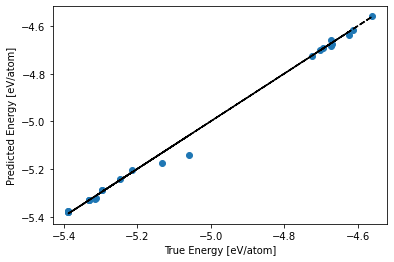

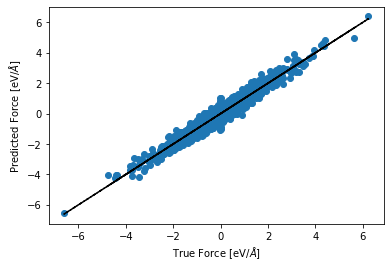

In [28]:
model_lin = LinearPotential()
model_lin.fit_from_features(tr_features, noise, e_t, f_t)

# evaluate its performances
%time predictions = model_lin.predict_from_features(val_features, forces=True)
ep = predictions['energy']
fp = predictions['forces']
print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

### Ensemble Model

CPU times: user 12.4 ms, sys: 4.08 ms, total: 16.5 ms
Wall time: 8.27 ms
MAE=0.007 RMSE=0.010 SUP=0.014 R2=0.999
MAE=0.106 RMSE=0.155 SUP=0.817 R2=0.969


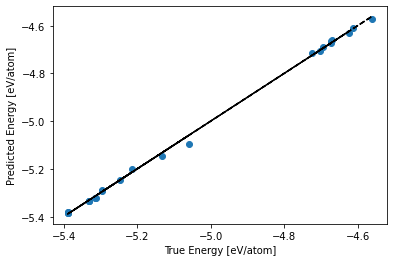

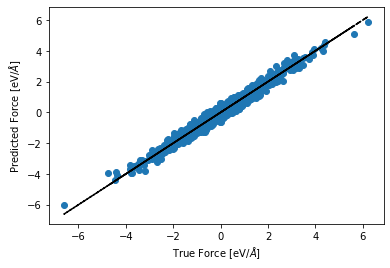

In [23]:
n_clusters = 4
# train the model
model_ens =  LPEnsamble(n_clusters=n_clusters, clustering_type='kmeans', baseline_percentile=0)
model_ens.fit_from_features(tr_features, e_t, f_t, noise)
# evaluate its performances
%time predictions = model_ens.predict_from_features(val_features, forces=True)
ep = predictions['energy']
fp = predictions['forces']
print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

### Ensemble Model with Baseline Model (LJ)

MAE=0.008 RMSE=0.011 SUP=0.014 R2=0.999
MAE=0.117 RMSE=0.178 SUP=1.345 R2=0.959


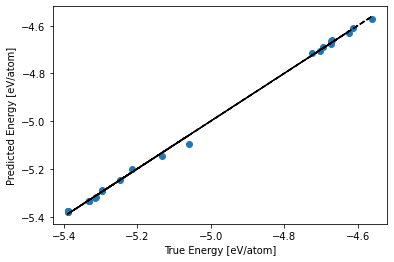

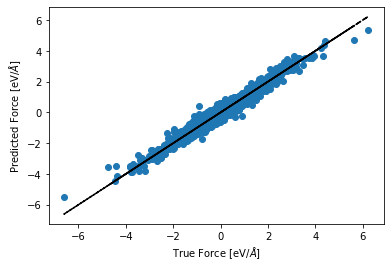

In [27]:
representation = AceGlobalRepresentation(5, 8, rcut, 14, energy_name=energy_name, force_name=force_name)
baseline = LennardJones(epsilon=2.2, sigma=2.2, rc=rcut, smooth=True)
model_ens_wb =  LPEnsamble(baseline_calculator=baseline, n_clusters=n_clusters,
                        clustering_type='kmeans', baseline_percentile=0.4)
model_ens_wb.fit(tr_traj, representation)

ep, fp = [], []
for i in val_traj:
    predictions = model_ens_wb.predict(i, forces=True)
    ep.extend(predictions['energy'])
    fp.extend(predictions['forces'])
ep = np.array(ep)
fp = np.array(fp)

print_score(ep/nat_val, e_val/nat_val)
print_score(fp.flatten(), f_val.flatten())

plt.scatter(e_val/nat_val, ep/nat_val)
plt.plot(e_val/nat_val, e_val/nat_val, 'k--')
plt.xlabel("True Energy [eV/atom]")
plt.ylabel("Predicted Energy [eV/atom]")
plt.show()

plt.scatter(f_val, fp)
plt.plot(f_val, f_val, 'k--')
plt.xlabel("True Force [eV/$\AA$]")
plt.ylabel("Predicted Force [eV/$\AA$]")
plt.show()

# EV Curves

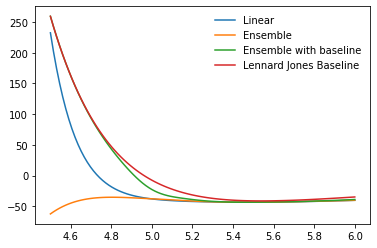

In [29]:
calc_lin = ASEMLCalculator(model_lin)
calc_ens = ASEMLCalculator(model_ens)
calc_ens_wb = ASEMLCalculator(model_ens_wb)
num = 100
en_lin = np.zeros(num)
en_ens = np.zeros(num)
en_ens_wb = np.zeros(num)
en_baseline = np.zeros(num)

distances = np.linspace(4.5, 6, num)
for i in range(num):
    atoms = bulk('Si', 'diamond', a=distances[i], cubic=True)
    atoms.set_calculator(calc_lin)
    en_lin[i] = atoms.get_potential_energy()
    
    atoms.set_calculator(calc_ens)
    en_ens[i] = atoms.get_potential_energy()

    atoms.set_calculator(calc_ens_wb)
    en_ens_wb[i] = atoms.get_potential_energy()
    
    atoms.set_calculator(baseline)
    en_baseline[i] = atoms.get_potential_energy()
    
plt.plot(distances, en_lin, label = 'Linear')
plt.plot(distances, en_ens, label = 'Ensemble')
plt.plot(distances, en_ens_wb, label = 'Ensemble with baseline')
plt.plot(distances, en_baseline, label = 'Lennard Jones Baseline')
plt.legend(frameon=False)
plt.show()

# MD Runs

In [30]:
atoms = bulk('Si', 'diamond', a=5.5, cubic=True)
atoms.set_calculator(calc_ens)

# Set the momenta corresponding to T=300K
MaxwellBoltzmannDistribution(atoms, temperature_K=5000)

# We want to run MD with constant energy using the VelocityVerlet algorithm.
dyn = VelocityVerlet(atoms, 2 * units.fs)  # 5 fs time step.

def printenergy(a):
    """Function to print the potential, kinetic and total energy"""
    epot = a.get_potential_energy() / len(a)
    ekin = a.get_kinetic_energy() / len(a)
    print('Energy per atom: Epot = %.3feV  Ekin = %.3feV (T=%3.0fK)  '
          'Etot = %.3feV' % (epot, ekin, ekin / (1.5 * units.kB), epot + ekin))

# Now run the dynamics
printenergy(atoms)
for i in range(10):
    dyn.run(100)
    printenergy(atoms)

Energy per atom: Epot = -5.415eV  Ekin = 0.635eV (T=4912K)  Etot = -4.780eV
Energy per atom: Epot = -5.000eV  Ekin = 0.233eV (T=1799K)  Etot = -4.767eV
Energy per atom: Epot = -5.213eV  Ekin = 0.438eV (T=3392K)  Etot = -4.774eV
Energy per atom: Epot = -5.065eV  Ekin = 0.290eV (T=2244K)  Etot = -4.775eV
Energy per atom: Epot = -4.992eV  Ekin = 0.224eV (T=1735K)  Etot = -4.768eV
Energy per atom: Epot = -5.123eV  Ekin = 0.349eV (T=2699K)  Etot = -4.775eV
Energy per atom: Epot = -4.977eV  Ekin = 0.223eV (T=1724K)  Etot = -4.754eV
Energy per atom: Epot = -5.145eV  Ekin = 0.368eV (T=2849K)  Etot = -4.777eV
Energy per atom: Epot = -5.095eV  Ekin = 0.319eV (T=2470K)  Etot = -4.776eV
Energy per atom: Epot = -5.243eV  Ekin = 0.465eV (T=3601K)  Etot = -4.777eV
Energy per atom: Epot = -5.167eV  Ekin = 0.390eV (T=3019K)  Etot = -4.777eV


In [31]:
atoms = bulk('Si', 'diamond', a=5.5, cubic=True)
atoms.set_calculator(calc_lin)
dyn = VelocityVerlet(atoms, 3 * units.fs)  # 5 fs time step.

%time dyn.run(100)

CPU times: user 8.87 s, sys: 19.7 s, total: 28.5 s
Wall time: 3.58 s


True

In [32]:
atoms = bulk('Si', 'diamond', a=5.5, cubic=True)
atoms.set_calculator(calc_ens)
dyn = VelocityVerlet(atoms, 3 * units.fs)  # 5 fs time step.

%time dyn.run(100)

CPU times: user 15.1 s, sys: 34.5 s, total: 49.6 s
Wall time: 6.28 s


True